# Notebook to Evaluate New Bathymetry as the run comes in

## Salinity top 5 m

In [7]:
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats

In [8]:
foramt = "{:.2}"
myformat = {'bias': foramt, 'rmse': foramt, 'swillmott': foramt, 'slopedev': foramt, 'const': foramt,
                         'systematic': foramt, 'nonsystematic':foramt, 
                    'spread': foramt}

In [9]:
def bias(df, obs, mod):
    diffy = df[mod] - df[obs]
    return diffy.count(), diffy.mean()

In [10]:
def rmse(df, obs, mod):
    return (np.sqrt(((df[mod] - df[obs])**2).mean()))

In [11]:
def swillmott(df, obs, mod):
    meanobs = df[obs].mean()
    return (((df[mod] - df[obs])**2).sum()
            /(( (df[mod] - meanobs).abs() + (df[obs] - meanobs).abs() )**2).sum())

In [12]:
def slope_inter(df, obs, mod):
    X = df[obs]
    y = df[mod]
    X2 = X**2
    X2 = X**2
    X3 = X**3
    X4 = X**4
    X5 = X**5
    X6 = X**6
    X = np.column_stack((X, X2, X3, X4, X5, X6))
    X = sm.add_constant(X)

    # Fit and make the predictions by the model
    model = sm.OLS(y, X, missing='drop').fit()
    predictions = model.predict(X)
    
    nonsyst = np.sqrt(((y - predictions)**2).mean())
    systematic = np.sqrt(((predictions - df[obs])**2).mean())
#    print (model.params)
    return predictions, model.params['x2'], model.params['x1'], model.params['const'], systematic, nonsyst

In [16]:
def spread(df, obs, mod):
    return 1 - ((df[mod] - df[mod].mean())**2).mean() / ((df[obs] - df[obs].mean())**2).mean() 

In [6]:
def read_pieces(pieces):
    temp1 = pd.read_csv(pieces[0])
    if 'ferry' in pieces[0]:
        temp1['k'] = 1.5
    for piece in pieces[1:]:
        nextpiece = pd.read_csv(piece)
        if 'ferry' in piece:
            nextpiece['k'] = 1.5
        temp1 = pd.concat([temp1, nextpiece], ignore_index=True)
    return temp1

In [18]:
def triple_plots(dowhich, temp1, temp2, temp3):
    No = "No"
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    if dowhich[0] != No:
        answer1 = plot_and_stats(fig, axs[0], temp1, dowhich[0])
    else:
        answer1 = No
    if dowhich[1] != No:
        answer2 = plot_and_stats(fig, axs[1], temp2, dowhich[1])
    else:
        answer2 = No
    if dowhich[2] != No:
        answer3 = plot_and_stats(fig, axs[2], temp3, dowhich[2])
    else:
        answer3 = No
    return answer1, answer2, answer3

In [20]:
def plot_and_stats(fig, ax, temp1, name):
    vmax = 34
    vmin = 0
    condition = temp1.k < 5
    title = 'Salinity top 5 m'
    counts, xedges, yedges, color = ax.hist2d(temp1.SA[condition], temp1.mod_vosaline[condition], 
                                           bins=np.arange(vmin, vmax, 0.5), norm=LogNorm());
    fig.colorbar(color, ax=ax)
    number, tbias = bias(temp1[condition], 'SA', 'mod_vosaline')
    trmse = rmse(temp1[condition], 'SA', 'mod_vosaline')
    tswillmott = swillmott(temp1[condition], 'SA', 'mod_vosaline')
    predictions, m2, m, c, syst, nonsyst = slope_inter(temp1[condition], 'SA', 'mod_vosaline')
    tspread = spread(temp1[condition], 'SA', 'mod_vosaline')
    ax.plot([vmin, vmax], [vmin, vmax], 'w-');
    xr = np.arange(vmin, vmax, 0.5)
    ax.plot(temp1.SA[condition], predictions, 'r.');
    ax.arrow(3, 27, 0, 1-tbias/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(3, 29, 0, -1+tbias/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(4, 27, 0, 1-syst/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(4, 29, 0, -1+syst/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(5, 27, 0, 1-nonsyst/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(5, 29, 0, -1+nonsyst/2, head_width=0.5, head_length=0.2, length_includes_head=True);
    Cp2 = {'number': number,
            'bias': tbias,
          'rmse': trmse,
          'swillmott': tswillmott,
          'slopedev': 1-m,
          'const': c,
          'systematic': syst,
          'nonsystematic': nonsyst,
          'spread': tspread}
    ax.text(3-0.2, 22, 'bias', rotation=90)
    ax.text(4-0.2, 21, 'systematic', rotation=90)
    ax.text(5-0.2, 20, 'non-systematic', rotation=90)
    ax.set_title(f'{name}, {title}');
    dCp2 = pd.DataFrame(data=Cp2, index=[name])
    return dCp2


In [196]:
pieces1 = ('/home/sallen/202007/H201812/ObsModel_H201812_ctd_20150101_20151231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_ctd_20160101_20161231.csv',
     #    '/home/sallen/202007/H201812/ObsModel_H201812_ctd_20170101_20171231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_psfts_20150101_20151231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_psfts_20160101_20161231.csv',
      #    '/home/sallen/202007/H201812/ObsModel_H201812_psfts_20170101_20171231.csv',
          '/home/sallen/202007/H201812/ObsModel_H201812_pugts_20150101_20151231.csv',
          '/home/sallen/202007/H201812/ObsModel_H201812_pugts_20160101_20161231.csv',
      #    '/home/sallen/202007/H201812/ObsModel_H201812_pugts_20170101_20171231.csv',
          )
pieces2 = (
          '/home/sallen/202007/H201812/ObsModel_H201812_ferry_20150101_20151231.csv',
          '/home/sallen/202007/H201812/ObsModel_H201812_ferry_20160101_20161231.csv',
      #    '/home/sallen/202007/H201812/ObsModel_H201812_ferry_20170101_20171231.csv'
         )

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812o,27425,-0.72,2.3,0.11,7.1,3.2e+01,0.8,2.1,-0.34
H201812f,251530,2.1,5.2,0.24,-0.65,1.1e+01,4.0,3.4,0.47


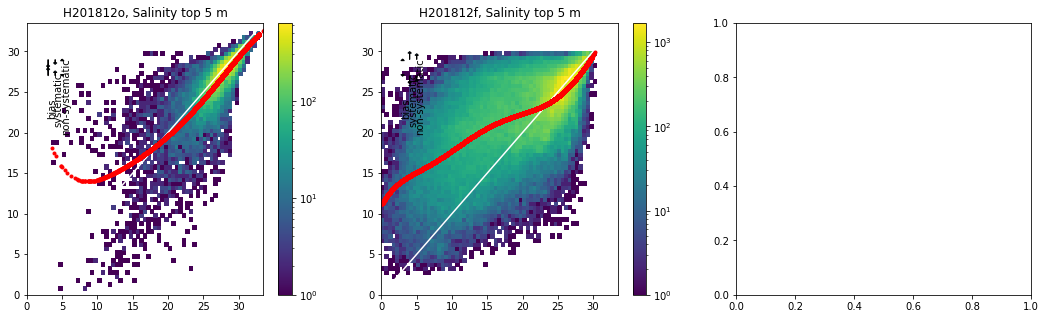

In [197]:
temp1 = read_pieces(pieces1)
#temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
#temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)

temp2 = read_pieces(pieces2)
temp2['SA'] = temp2['salinity (g/kg)']
temp2.drop(columns='Unnamed: 0', inplace=True)
temp2.drop_duplicates(inplace=True)

dowhich = ['H201812o', 'H201812f', 'No'] 

d201812o, d201812f, stuff = triple_plots(dowhich, temp1, cleanup_ferry(temp2), temp1)
alltogether = pd.concat([d201812o, d201812f], axis=0)
alltogether.style.format(myformat).apply(highlight_max_min)

In [198]:
pieces1 = ('/home/sallen/202007/H201905/ObsModel_H201905_ctd_20150101_20151231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_ctd_20160101_20161231.csv',
       #  '/home/sallen/202007/H201905/ObsModel_H201905_ctd_20170101_20171231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_psfts_20150101_20151231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_psfts_20160101_20161231.csv',
       #   '/home/sallen/202007/H201905/ObsModel_H201905_psfts_20170101_20171231.csv',
          '/home/sallen/202007/H201905/ObsModel_H201905_pugts_20150101_20151231.csv',
          '/home/sallen/202007/H201905/ObsModel_H201905_pugts_20160101_20161231.csv',
       #   '/home/sallen/202007/H201905/ObsModel_H201905_pugts_20170101_20171231.csv',
          )
pieces2 = (
          '/home/sallen/202007/H201905/ObsModel_H201905_ferry_20150101_20151231.csv',
          '/home/sallen/202007/H201905/ObsModel_H201905_ferry_20160101_20161231.csv',
       #   '/home/sallen/202007/H201905/ObsModel_H201905_ferry_20170101_20171231.csv'
         )

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812o,27425,-0.72,2.3,0.11,7.1,3.2e+01,0.8,2.1,-0.34
H201812f,251530,2.1,5.2,0.24,-0.65,1.1e+01,4.0,3.4,0.47
H201905o,27425,-0.76,2.3,0.11,1e+01,4e+01,0.83,2.1,-0.33
H201905f,251528,2.0,5.2,0.24,-0.36,1.1e+01,3.9,3.5,0.47


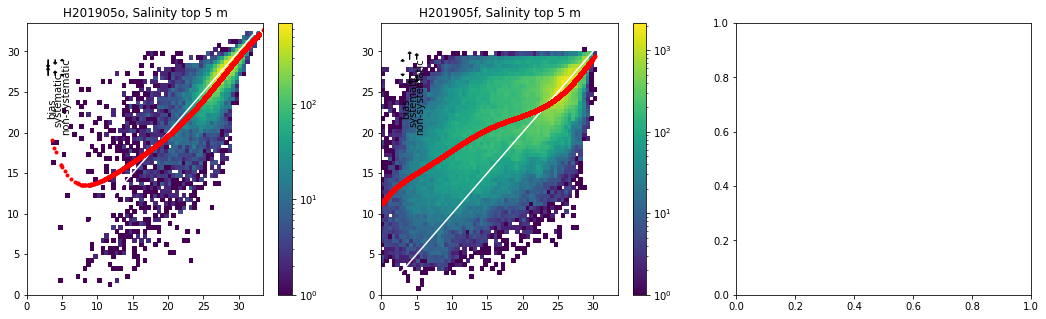

In [199]:
temp1 = read_pieces(pieces1)
#temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
#temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)

temp2 = read_pieces(pieces2)
temp2['SA'] = temp2['salinity (g/kg)']
temp2.drop(columns='Unnamed: 0', inplace=True)
temp2.drop_duplicates(inplace=True)

dowhich = ['H201905o', 'H201905f', 'No'] 

d201905o, d201905f, stuff = triple_plots(dowhich, temp1, cleanup_ferry(temp2), temp1)
alltogether = pd.concat([d201812o, d201812f, d201905o, d201905f], axis=0)
alltogether.style.format(myformat).apply(highlight_max_min)

In [200]:
pieces1 = ('/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ctd_20150101_20151231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TSPUG_20150101-20151231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ctd_20160101_20161231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TSPUG_20160101-20161231.csv',
   #      '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TS_20170101-20170331.csv',
   #      '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TS_20170401-20170630.csv',
   #      '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TS_20170701-20170930.csv',
   #      '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TS_20171001-20171231.csv',
   #      '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TSPUG_20170101-20171231.csv',   
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_psfts_20150101_20151231.csv',
          '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_psfts_20160101_20161231.csv',
   #       '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_psfts_20170101_20171231.csv'
         )
pieces2 = (
      '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20150101_20150331.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20150401_20150630.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20150701_20150930.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20151001_20151231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20160101_20160331.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20160301_20160630.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20160601_20160930.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20161001_20161231.csv',
   #      '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20170101_20170331.csv',
   #      '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20170401_20170630.csv',
   #      '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20170701_20170930.csv',
   #      '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20171001_20171231.csv',
)

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812o,27425,-0.72,2.3,0.11,7.1,3.2e+01,0.8,2.1,-0.34
H201812f,251530,2.1,5.2,0.24,-0.65,1.1e+01,4.0,3.4,0.47
H201905o,27425,-0.76,2.3,0.11,1e+01,4e+01,0.83,2.1,-0.33
H201905f,251528,2.0,5.2,0.24,-0.36,1.1e+01,3.9,3.5,0.47
Cp2o,27425,-0.74,2.2,0.11,7.8,3.4e+01,0.81,2.1,-0.35
Cp2f,257271,2.1,5.3,0.25,-0.31,1.2e+01,4.0,3.5,0.47


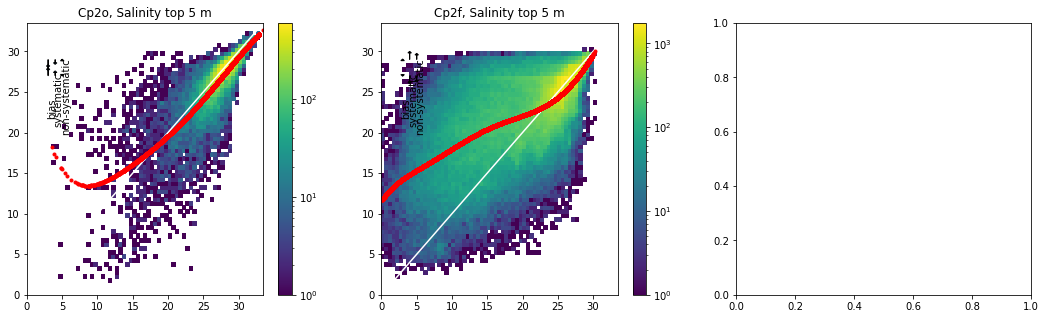

In [201]:
temp1 = read_pieces(pieces1)
#temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
#temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)

temp2 = read_pieces(pieces2)
temp2['SA'] = temp2['salinity (g/kg)']
temp2.drop(columns='Unnamed: 0', inplace=True)
temp2.drop_duplicates(inplace=True)

dowhich = ['Cp2o', 'Cp2f', 'No'] 

Cp2o, Cp2f, stuff = triple_plots(dowhich, temp1, cleanup_ferry(temp2), temp1)
alltogether = pd.concat([d201812o, d201812f, d201905o, d201905f, Cp2o, Cp2f], axis=0)
alltogether.style.format(myformat).apply(highlight_max_min)

In [202]:
pieces1 = ('/home/sallen/202007/202007D-again/ObsModel_202007D-again_TS_20150101-20150331.csv',
         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_TS_20150401-20150630.csv',
         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_TS_20150701-20150930.csv',
         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_TS_20151001-20151231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_psfts_20150101_20151231.csv',
         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_pugts_20150101_20151231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_ctd_20160101_20161231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_psfts_20160101_20161231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_pugts_20160101_20161231.csv',
 #         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_ctd_20170101_20171231.csv',
 #         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_psfts_20170101_20171231.csv',
 #         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_pugts_20170101_20171231.csv',
         )
pieces2 = (
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_ferry_20150101_20151231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_ferry_20160101_20161231.csv',
 #         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_ferry_20170101_20171231.csv'
        )

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812o,27425,-0.72,2.3,0.11,7.1,3.2e+01,0.8,2.1,-0.34
H201812f,251530,2.1,5.2,0.24,-0.65,1.1e+01,4.0,3.4,0.47
H201905o,27425,-0.76,2.3,0.11,1e+01,4e+01,0.83,2.1,-0.33
H201905f,251528,2.0,5.2,0.24,-0.36,1.1e+01,3.9,3.5,0.47
Cp2o,27425,-0.74,2.2,0.11,7.8,3.4e+01,0.81,2.1,-0.35
Cp2f,257271,2.1,5.3,0.25,-0.31,1.2e+01,4.0,3.5,0.47
Dagaino,27365,-0.75,2.2,0.11,1.1e+01,4e+01,0.83,2.1,-0.35
Dagainf,251530,2.0,5.3,0.25,-0.54,1e+01,4.0,3.5,0.48


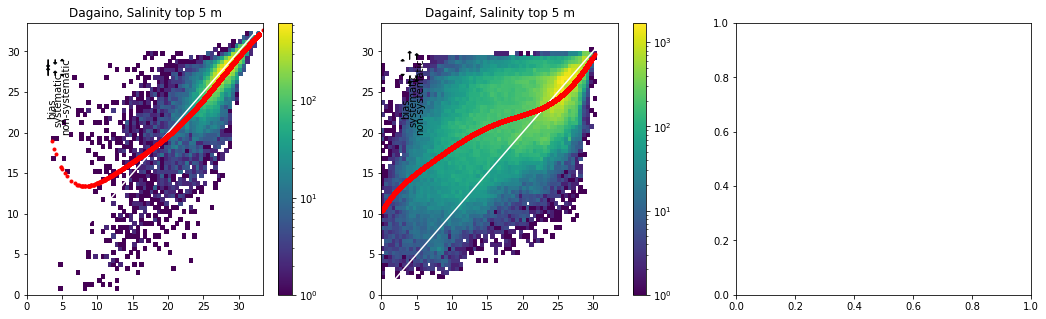

In [203]:
temp1 = read_pieces(pieces1)
#temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
#temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)

temp2 = read_pieces(pieces2)
temp2['SA'] = temp2['salinity (g/kg)']
temp2.drop(columns='Unnamed: 0', inplace=True)
temp2.drop_duplicates(inplace=True)

dowhich = ['Dagaino', 'Dagainf', 'No'] 

Dagaino, Dagainf, stuff = triple_plots(dowhich, temp1, cleanup_ferry(temp2), temp1)
alltogether = pd.concat([d201812o, d201812f, d201905o, d201905f, Cp2o, Cp2f, Dagaino, Dagainf], axis=0)
alltogether.style.format(myformat).apply(highlight_max_min)

In [204]:
pieces1 = ('/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_ctd_20150101_20151231.csv',
        '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_ctd_20160101_20161231.csv',
  #      '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_ctd_20170101_20171231.csv',
        '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_psfts_20150101_20151231.csv',
        '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_psfts_20160101_20161231.csv',
  #      '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_psfts_20170101_20171231.csv',
        '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_pugts_20150101_20151231.csv',
        '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_pugts_20160101_20161231.csv',
  #      '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_pugts_20170101_20171231.csv', 
         )
pieces2 = (
         '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_ferry_20150101_20151231.csv',     
         '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_ferry_20160101_20161231.csv',
  #       '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_ferry_20170101_20171231.csv'
         )

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812o,27425,-0.72,2.3,0.11,7.1,3.2e+01,0.8,2.1,-0.34
H201812f,251530,2.1,5.2,0.24,-0.65,1.1e+01,4.0,3.4,0.47
H201905o,27425,-0.76,2.3,0.11,1e+01,4e+01,0.83,2.1,-0.33
H201905f,251528,2.0,5.2,0.24,-0.36,1.1e+01,3.9,3.5,0.47
Cp2o,27425,-0.74,2.2,0.11,7.8,3.4e+01,0.81,2.1,-0.35
Cp2f,257271,2.1,5.3,0.25,-0.31,1.2e+01,4.0,3.5,0.47
Dagaino,27365,-0.75,2.2,0.11,1.1e+01,4e+01,0.83,2.1,-0.35
Dagainf,251530,2.0,5.3,0.25,-0.54,1e+01,4.0,3.5,0.48
DnoCilo,27425,-0.77,2.3,0.11,1e+01,3.9e+01,0.83,2.1,-0.35
DnoCilf,251528,2.1,5.3,0.25,-1.3,9.7,4.0,3.4,0.48


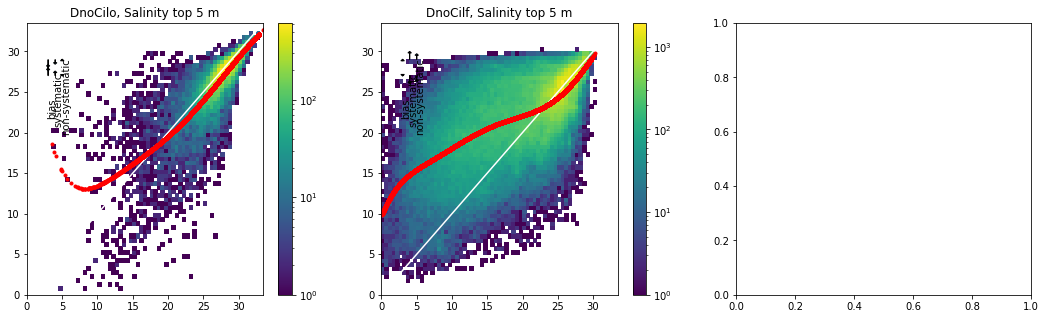

In [205]:
temp1 = read_pieces(pieces1)
#temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
#temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)

temp2 = read_pieces(pieces2)
temp2['SA'] = temp2['salinity (g/kg)']
temp2.drop(columns='Unnamed: 0', inplace=True)
temp2.drop_duplicates(inplace=True)

dowhich = ['DnoCilo', 'DnoCilf', 'No'] 

DnoCilo, DnoCilf, stuff = triple_plots(dowhich, temp1, cleanup_ferry(temp2), temp1)
alltogether = pd.concat([d201812o, d201812f, d201905o, d201905f, Cp2o, Cp2f, Dagaino, Dagainf,
                        DnoCilo, DnoCilf], axis=0)
alltogether.style.format(myformat).apply(highlight_max_min)

In [206]:
pieces1 = ('/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_ctd_20150101_20151231.csv',
          '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_psfts_20150101_20151231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_pugts_20150101_20151231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_ctd_20160101_20161231.csv',
          '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_psfts_20160101_20161231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_pugts_20160101_20161231.csv',
      #   '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_ctd_20170101_20171231.csv',
      #    '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_psfts_20170101_20171231.csv',
      #   '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_pugts_20170101_20171231.csv',
         )
pieces2 = (
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_ferry_20150101_20151231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_ferry_20160101_20161231.csv',
      #   '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_ferry_20170101_20171231.csv'
         )

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812o,27425,-0.72,2.3,0.11,7.1,3.2e+01,0.8,2.1,-0.34
H201905o,27425,-0.76,2.3,0.11,1e+01,4e+01,0.83,2.1,-0.33
Cp2o,27425,-0.74,2.2,0.11,7.8,3.4e+01,0.81,2.1,-0.35
Dagaino,27365,-0.75,2.2,0.11,1.1e+01,4e+01,0.83,2.1,-0.35
DnoCilo,27425,-0.77,2.3,0.11,1e+01,3.9e+01,0.83,2.1,-0.35
DLowRo,27425,-0.76,2.2,0.11,1.5e+01,5.1e+01,0.83,2.1,-0.34


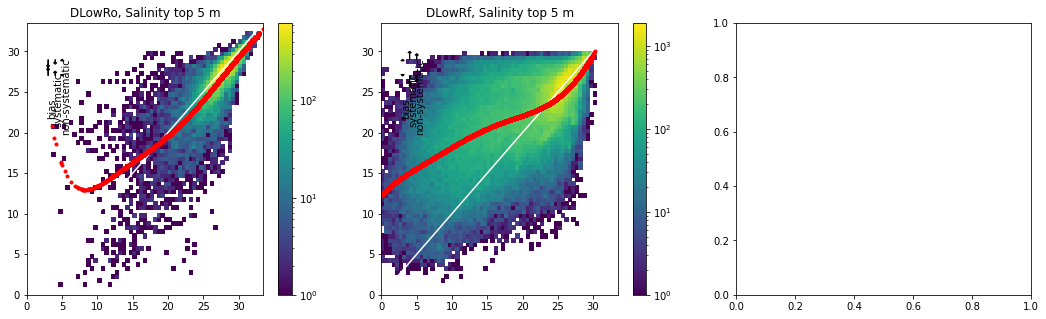

In [207]:
temp1 = read_pieces(pieces1)
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)

temp2 = read_pieces(pieces2)
temp2['SA'] = temp2['salinity (g/kg)']
temp2.drop(columns='Unnamed: 0', inplace=True)
temp2.drop_duplicates(inplace=True)

dowhich = ['DLowRo', 'DLowRf', 'No'] 

DLowRo, DLowRf, stuff = triple_plots(dowhich, temp1, cleanup_ferry(temp2), temp1)

alltogethero = pd.concat([d201812o, d201905o,  Cp2o,  Dagaino, 
                        DnoCilo,  DLowRo,], axis=0)
alltogetherf = pd.concat([d201812f,  d201905f,  Cp2f,  Dagainf,
                         DnoCilf,  DLowRf], axis=0)
alltogethero.style.format(myformat).apply(highlight_max_min)


In [208]:
alltogetherf.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812f,251530,2.1,5.2,0.24,-0.65,1.1e+01,4.0,3.4,0.47
H201905f,251528,2.0,5.2,0.24,-0.36,1.1e+01,3.9,3.5,0.47
Cp2f,257271,2.1,5.3,0.25,-0.31,1.2e+01,4.0,3.5,0.47
Dagainf,251530,2.0,5.3,0.25,-0.54,1e+01,4.0,3.5,0.48
DnoCilf,251528,2.1,5.3,0.25,-1.3,9.7,4.0,3.4,0.48
DLowRf,251529,2.1,5.3,0.25,-0.03,1.2e+01,4.1,3.5,0.49


In [209]:
pieces1 = (
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ctd_20150101_20151231.csv',
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ctd_20160101_20161231.csv',
 #         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ctd_20170101_20171231.csv',
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_TSPUG_20150101-20151231.csv',
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_pugts_20160101_20161231.csv',
 #        '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_pugts_20170101_20171231.csv',
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_psfts_20150101_20151231.csv',
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_psfts_20160101_20161231.csv',
  #       '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_psfts_20170101_20171231.csv',
)
pieces2 = (
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ferry_20150101_20150331.csv',
        '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ferry_20150401_20150630.csv',
        '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ferry_20150701_20150930.csv',
        '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ferry_20151001_20151231.csv',
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ferry_20160101_20160331.csv',
    '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ferry_20160401_20160630.csv',
    '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ferry_20160701_20160930.csv',
    '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ferry_20161001_20161231.csv',
   #      '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ferry_20170101_20171231.csv'
)
pieces3 = ('/home/sallen/202007/202007C-p3/ObsModel_202007Cp3f0_ferry_20150101_20151231.csv',
          '/home/sallen/202007/202007C-p3/ObsModel_202007Cp3f0_ferry_20160101_20161231.csv')

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812o,27425,-0.72,2.3,0.11,7.1,3.2e+01,0.8,2.1,-0.34
H201905o,27425,-0.76,2.3,0.11,1e+01,4e+01,0.83,2.1,-0.33
Cp2o,27425,-0.74,2.2,0.11,7.8,3.4e+01,0.81,2.1,-0.35
Dagaino,27365,-0.75,2.2,0.11,1.1e+01,4e+01,0.83,2.1,-0.35
DnoCilo,27425,-0.77,2.3,0.11,1e+01,3.9e+01,0.83,2.1,-0.35
DLowRo,27425,-0.76,2.2,0.11,1.5e+01,5.1e+01,0.83,2.1,-0.34
Cp3o,27425,-0.46,1.9,0.09,7.8,3.3e+01,0.59,1.8,-0.21


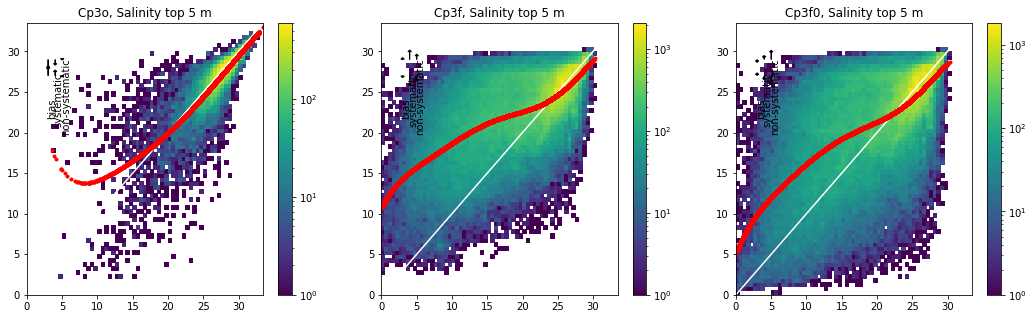

In [210]:
temp1 = read_pieces(pieces1)
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)

temp2 = read_pieces(pieces2)
temp2['SA'] = temp2['salinity (g/kg)']
temp2.drop(columns='Unnamed: 0', inplace=True)
temp2.drop_duplicates(inplace=True)

temp3 = read_pieces(pieces3)
temp3['SA'] = temp3['salinity (g/kg)']
temp3.drop(columns='Unnamed: 0', inplace=True)
temp3.drop_duplicates(inplace=True)

dowhich = ['Cp3o', 'Cp3f', 'Cp3f0'] 

Cp3o, Cp3f, Cp3f0 = triple_plots(dowhich, temp1, cleanup_ferry(temp2), cleanup_ferry(temp3))

alltogethero = pd.concat([d201812o, d201905o,  Cp2o,  Dagaino, 
                        DnoCilo,  DLowRo, Cp3o], axis=0)
alltogetherf = pd.concat([d201812f,  d201905f,  Cp2f,  Dagainf,
                         DnoCilf,  DLowRf, Cp3f, Cp3f0], axis=0)
alltogethero.style.format(myformat).apply(highlight_max_min)

In [211]:
alltogetherf.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812f,251530,2.1,5.2,0.24,-0.65,1.1e+01,4.0,3.4,0.47
H201905f,251528,2.0,5.2,0.24,-0.36,1.1e+01,3.9,3.5,0.47
Cp2f,257271,2.1,5.3,0.25,-0.31,1.2e+01,4.0,3.5,0.47
Dagainf,251530,2.0,5.3,0.25,-0.54,1e+01,4.0,3.5,0.48
DnoCilf,251528,2.1,5.3,0.25,-1.3,9.7,4.0,3.4,0.48
DLowRf,251529,2.1,5.3,0.25,-0.03,1.2e+01,4.1,3.5,0.49
Cp3f,249027,2.5,5.5,0.26,-0.8,1.1e+01,4.3,3.3,0.52
Cp3f0,251533,1.3,5.2,0.21,-1.2,5.1,3.0,4.3,0.2


In [212]:
pieces1 = ('/home/sallen/202007/202007F/ObsModel_202007F_ctd_20150101_20151231.csv',
          '/home/sallen/202007/202007F/ObsModel_202007F_psfts_20150101_20151231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_pugts_20150101_20151231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_ctd_20160101_20161231.csv',
          '/home/sallen/202007/202007F/ObsModel_202007F_psfts_20160101_20161231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_pugts_20160101_20161231.csv',
        # '/home/sallen/202007/202007F/ObsModel_202007F_ctd_20170101_20171231.csv',
        #  '/home/sallen/202007/202007F/ObsModel_202007F_psfts_20170101_20171231.csv',
        # '/home/sallen/202007/202007F/ObsModel_202007F_pugts_20170101_20171231.csv',
          )
pieces2 = (
         '/home/sallen/202007/202007F/ObsModel_202007F_ferry_20150101_20151231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_ferry_20160101_20161231.csv',
        # '/home/sallen/202007/202007F/ObsModel_202007F_ferry_20170101_20171231.csv'
         )
pieces3 = (
       '/home/sallen/202007/202007F/ObsModel_202007F0f_ferry_20150101_20151231.csv',
    '/home/sallen/202007/202007F/ObsModel_202007F0f_ferry_20160101_20161231.csv',
)

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812o,27425,-0.72,2.3,0.11,7.1,3.2e+01,0.8,2.1,-0.34
H201905o,27425,-0.76,2.3,0.11,1e+01,4e+01,0.83,2.1,-0.33
Cp2o,27425,-0.74,2.2,0.11,7.8,3.4e+01,0.81,2.1,-0.35
Dagaino,27365,-0.75,2.2,0.11,1.1e+01,4e+01,0.83,2.1,-0.35
DnoCilo,27425,-0.77,2.3,0.11,1e+01,3.9e+01,0.83,2.1,-0.35
DLowRo,27425,-0.76,2.2,0.11,1.5e+01,5.1e+01,0.83,2.1,-0.34
Cp3o,27425,-0.46,1.9,0.09,7.8,3.3e+01,0.59,1.8,-0.21
Fo,27425,-0.48,1.9,0.088,8.7,3.5e+01,0.59,1.8,-0.21


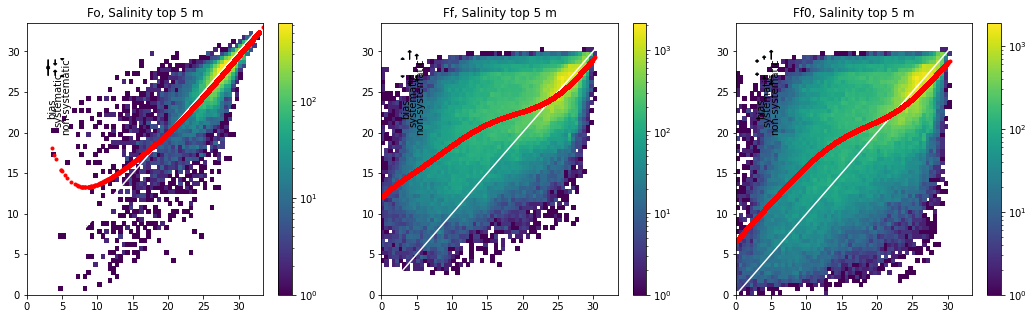

In [213]:
temp1 = read_pieces(pieces1)
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)

temp2 = read_pieces(pieces2)
temp2['SA'] = temp2['salinity (g/kg)']
temp2.drop(columns='Unnamed: 0', inplace=True)
temp2.drop_duplicates(inplace=True)

temp3 = read_pieces(pieces3)
temp3['SA'] = temp3['salinity (g/kg)']
temp3.drop(columns='Unnamed: 0', inplace=True)
temp3.drop_duplicates(inplace=True)

dowhich = ['Fo', 'Ff', 'Ff0'] 

Fo, Ff, Ff0 = triple_plots(dowhich, temp1, cleanup_ferry(temp2), cleanup_ferry(temp3))

alltogethero = pd.concat([d201812o, d201905o,  Cp2o,  Dagaino, 
                        DnoCilo,  DLowRo, Cp3o, Fo], axis=0)
alltogetherf = pd.concat([d201812f,  d201905f,  Cp2f,  Dagainf,
                         DnoCilf,  DLowRf, Cp3f, Ff, Cp3f0, Ff0], axis=0)
alltogethero.style.format(myformat).apply(highlight_max_min)

In [214]:
alltogetherf.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812f,251530,2.1,5.2,0.24,-0.65,1.1e+01,4.0,3.4,0.47
H201905f,251528,2.0,5.2,0.24,-0.36,1.1e+01,3.9,3.5,0.47
Cp2f,257271,2.1,5.3,0.25,-0.31,1.2e+01,4.0,3.5,0.47
Dagainf,251530,2.0,5.3,0.25,-0.54,1e+01,4.0,3.5,0.48
DnoCilf,251528,2.1,5.3,0.25,-1.3,9.7,4.0,3.4,0.48
DLowRf,251529,2.1,5.3,0.25,-0.03,1.2e+01,4.1,3.5,0.49
Cp3f,249027,2.5,5.5,0.26,-0.8,1.1e+01,4.3,3.3,0.52
Ff,251528,2.4,5.4,0.25,0.038,1.2e+01,4.2,3.3,0.51
Cp3f0,251533,1.3,5.2,0.21,-1.2,5.1,3.0,4.3,0.2
Ff0,251530,1.3,5.2,0.2,-0.15,6.5,2.9,4.3,0.18


In [224]:
pieces1 = ('/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_ctd_20150101_20151231.csv',
          '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_psfts_20150101_20151231.csv',
          '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_pugts_20150101_20151231.csv',
           '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_ctd_20160101_20161231.csv',
          '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_psfts_20160101_20161231.csv',
          '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_pugts_20160101_20161231.csv',
          )
pieces2 = ('/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_ferry_20150101_20150331.csv',
           '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_ferry_20150401_20150630.csv',
           '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_ferry_20150701_20150930.csv',
           '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_ferry_20151001_20151231.csv',
          '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_ferry_20160101_20161231.csv',)
pieces3 = (
          '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1f0_ferry_20150101_20151231.csv',
    '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1f0_ferry_20160101_20161231.csv',
         )

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812o,27425,-0.72,2.3,0.11,7.1,3.2e+01,0.8,2.1,-0.34
H201905o,27425,-0.76,2.3,0.11,1e+01,4e+01,0.83,2.1,-0.33
Cp2o,27425,-0.74,2.2,0.11,7.8,3.4e+01,0.81,2.1,-0.35
Dagaino,27365,-0.75,2.2,0.11,1.1e+01,4e+01,0.83,2.1,-0.35
DnoCilo,27425,-0.77,2.3,0.11,1e+01,3.9e+01,0.83,2.1,-0.35
DLowRo,27425,-0.76,2.2,0.11,1.5e+01,5.1e+01,0.83,2.1,-0.34
Cp3o,27425,-0.46,1.9,0.09,7.8,3.3e+01,0.59,1.8,-0.21
Fo,27425,-0.48,1.9,0.088,8.7,3.5e+01,0.59,1.8,-0.21
Gp1o,27398,-0.4,1.8,0.079,4.7,2e+01,0.5,1.8,-0.19


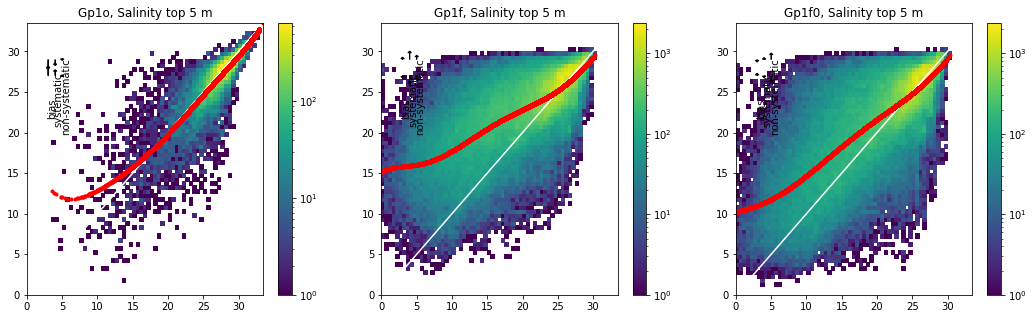

In [225]:
temp1 = read_pieces(pieces1)
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)

temp2 = read_pieces(pieces2)
temp2['SA'] = temp2['salinity (g/kg)']
temp2.drop(columns='Unnamed: 0', inplace=True)
temp2.drop_duplicates(inplace=True)

temp3 = read_pieces(pieces3)
temp3['SA'] = temp3['salinity (g/kg)']
temp3.drop(columns='Unnamed: 0', inplace=True)
temp3.drop_duplicates(inplace=True)

dowhich = ['Gp1o', 'Gp1f', 'Gp1f0'] 

Gp1o, Gp1f, Gp1f0 = triple_plots(dowhich, temp1[temp1.mod_vosaline != 0], cleanup_ferry(temp2), cleanup_ferry(temp3))

alltogethero = pd.concat([d201812o, d201905o,  Cp2o,  Dagaino, 
                        DnoCilo,  DLowRo, Cp3o, Fo, Gp1o], axis=0)
alltogetherf = pd.concat([d201812f,  d201905f,  Cp2f,  Dagainf,
                         DnoCilf,  DLowRf, Cp3f, Ff, Gp1f, Cp3f0, Ff0, Gp1f0], axis=0)
alltogethero.style.format(myformat).apply(highlight_max_min)

In [226]:
alltogetherf.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812f,251530,2.1,5.2,0.24,-0.65,1.1e+01,4.0,3.4,0.47
H201905f,251528,2.0,5.2,0.24,-0.36,1.1e+01,3.9,3.5,0.47
Cp2f,257271,2.1,5.3,0.25,-0.31,1.2e+01,4.0,3.5,0.47
Dagainf,251530,2.0,5.3,0.25,-0.54,1e+01,4.0,3.5,0.48
DnoCilf,251528,2.1,5.3,0.25,-1.3,9.7,4.0,3.4,0.48
DLowRf,251529,2.1,5.3,0.25,-0.03,1.2e+01,4.1,3.5,0.49
Cp3f,249027,2.5,5.5,0.26,-0.8,1.1e+01,4.3,3.3,0.52
Ff,251528,2.4,5.4,0.25,0.038,1.2e+01,4.2,3.3,0.51
Gp1f,250589,2.6,5.1,0.23,0.49,1.5e+01,4.1,3.1,0.51
Cp3f0,251533,1.3,5.2,0.21,-1.2,5.1,3.0,4.3,0.2


In [227]:
pieces1 = ('/home/sallen/202007/202007G-p2/ObsModel_202007Gp2_ctd_20150101_20151231.csv',
          '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2_psfts_20150101_20151231.csv',
          '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2_pugts_20150101_20151231.csv',
        '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2f0_ctd_20160101_20161231.csv',
           '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2f0_psfts_20160101_20161231.csv',
           '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2f0_pugts_20160101_20161231.csv'
         )
pieces2 = (
          '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2_ferry_20150101_20151231.csv',
   
         )
pieces3 = (
    '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2f0_ferry_20150101_20151231.csv',
    '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2f0_ferry_20160101_20161231.csv',
)

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812o,27425,-0.72,2.3,0.11,7.1,3.2e+01,0.8,2.1,-0.34
H201905o,27425,-0.76,2.3,0.11,1e+01,4e+01,0.83,2.1,-0.33
Cp2o,27425,-0.74,2.2,0.11,7.8,3.4e+01,0.81,2.1,-0.35
Dagaino,27365,-0.75,2.2,0.11,1.1e+01,4e+01,0.83,2.1,-0.35
DnoCilo,27425,-0.77,2.3,0.11,1e+01,3.9e+01,0.83,2.1,-0.35
DLowRo,27425,-0.76,2.2,0.11,1.5e+01,5.1e+01,0.83,2.1,-0.34
Cp3o,27425,-0.46,1.9,0.09,7.8,3.3e+01,0.59,1.8,-0.21
Fo,27425,-0.48,1.9,0.088,8.7,3.5e+01,0.59,1.8,-0.21
Gp1o,27398,-0.4,1.8,0.079,4.7,2e+01,0.5,1.8,-0.19
Gp2o,27398,-0.33,1.9,0.083,-1.6,7.5,0.46,1.8,-0.2


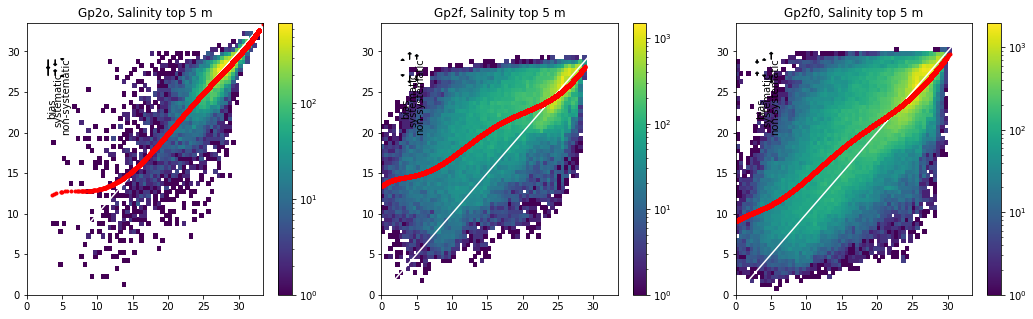

In [228]:
temp1 = read_pieces(pieces1)
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)

temp2 = read_pieces(pieces2)
temp2['SA'] = temp2['salinity (g/kg)']
temp2.drop(columns='Unnamed: 0', inplace=True)
temp2.drop_duplicates(inplace=True)

temp3 = read_pieces(pieces3)
temp3['SA'] = temp3['salinity (g/kg)']
temp3.drop(columns='Unnamed: 0', inplace=True)
temp3.drop_duplicates(inplace=True)

dowhich = ['Gp2o', 'Gp2f', 'Gp2f0'] 

Gp2o, Gp2f, Gp2f0 = triple_plots(dowhich, temp1[temp1.mod_vosaline != 0], cleanup_ferry(temp2), cleanup_ferry(temp3))

alltogethero = pd.concat([d201812o, d201905o,  Cp2o,  Dagaino, 
                        DnoCilo,  DLowRo, Cp3o, Fo, Gp1o, Gp2o], axis=0)
alltogetherf = pd.concat([d201812f,  d201905f,  Cp2f,  Dagainf,
                         DnoCilf,  DLowRf, Cp3f, Ff, Gp1f, Cp3f0, Ff0, Gp1f0, Gp2f0], axis=0)
alltogethero.style.format(myformat).apply(highlight_max_min)

In [229]:
alltogetherf.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812f,251530,2.1,5.2,0.24,-0.65,1.1e+01,4.0,3.4,0.47
H201905f,251528,2.0,5.2,0.24,-0.36,1.1e+01,3.9,3.5,0.47
Cp2f,257271,2.1,5.3,0.25,-0.31,1.2e+01,4.0,3.5,0.47
Dagainf,251530,2.0,5.3,0.25,-0.54,1e+01,4.0,3.5,0.48
DnoCilf,251528,2.1,5.3,0.25,-1.3,9.7,4.0,3.4,0.48
DLowRf,251529,2.1,5.3,0.25,-0.03,1.2e+01,4.1,3.5,0.49
Cp3f,249027,2.5,5.5,0.26,-0.8,1.1e+01,4.3,3.3,0.52
Ff,251528,2.4,5.4,0.25,0.038,1.2e+01,4.2,3.3,0.51
Gp1f,250589,2.6,5.1,0.23,0.49,1.5e+01,4.1,3.1,0.51
Cp3f0,251533,1.3,5.2,0.21,-1.2,5.1,3.0,4.3,0.2


In [23]:
def highlight_max_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = abs(s) == abs(s).max()
    is_min = abs(s) == abs(s).min()
    color = []
    for v, v2 in zip(is_max, is_min):
        if v:
            color.append('red')
        elif v2:
            color.append('darkgreen')
        else:
            color.append('black')
    return ['color: %s' % color[i] for i in range(len(is_max))]

In [67]:
## Now look at Distribution

In [122]:
pieces = (#'/home/sallen/202007/202007G-p2/ObsModel_202007Gp2_ctd_20150101_20151231.csv',
          #'/home/sallen/202007/202007G-p2/ObsModel_202007Gp2_psfts_20150101_20151231.csv',
          #'/home/sallen/202007/202007G-p2/ObsModel_202007Gp2_pugts_20150101_20151231.csv',
          '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2_ferry_20150101_20151231.csv',
           '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2_ferry_20150101_20151231.csv'
         )

In [123]:
temp1 = read_pieces(pieces)
#temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)

In [124]:
pieces = (#'/home/sallen/202007/202007F/ObsModel_202007F_ctd_20150101_20151231.csv',
          #'/home/sallen/202007/202007F/ObsModel_202007F_psfts_20150101_20151231.csv',
         #'/home/sallen/202007/202007F/ObsModel_202007F_pugts_20150101_20151231.csv',
        # '/home/sallen/202007/202007F/ObsModel_202007F_ctd_20160101_20161231.csv',
        #  '/home/sallen/202007/202007F/ObsModel_202007F_psfts_20160101_20161231.csv',
        # '/home/sallen/202007/202007F/ObsModel_202007F_pugts_20160101_20161231.csv',
        # '/home/sallen/202007/202007F/ObsModel_202007F_ctd_20170101_20171231.csv',
        #  '/home/sallen/202007/202007F/ObsModel_202007F_psfts_20170101_20171231.csv',
        # '/home/sallen/202007/202007F/ObsModel_202007F_pugts_20170101_20171231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_ferry_20150101_20151231.csv',
    '/home/sallen/202007/202007F/ObsModel_202007F_ferry_20160101_20161231.csv',
        # '/home/sallen/202007/202007F/ObsModel_202007F_ferry_20160101_20161231.csv',
        # '/home/sallen/202007/202007F/ObsModel_202007F_ferry_20170101_20171231.csv'
         )

In [125]:
temp2 = read_pieces(pieces)
#temp2['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
temp2['SA'] = temp2['salinity (g/kg)']
temp2.drop(columns='Unnamed: 0', inplace=True)
temp2.drop_duplicates(inplace=True)

In [126]:
pieces = (
         '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_ferry_20150101_20150331.csv',
          '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_ferry_20150401_20150630.csv',
          '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_ferry_20150701_20150930.csv',
          '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_ferry_20151001_20151231.csv',
    '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_ferry_20160101_20161231.csv',
         )

In [127]:
temp3 = read_pieces(pieces)
#temp2['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
temp3['SA'] = temp3['salinity (g/kg)']
temp3.drop(columns='Unnamed: 0', inplace=True)
temp3.drop_duplicates(inplace=True)

In [128]:
pieces = (
         '/home/sallen/202007/202007F/ObsModel_202007F0f_ferry_20150101_20151231.csv',
    '/home/sallen/202007/202007F/ObsModel_202007F0f_ferry_20160101_20161231.csv',
         )

In [129]:
temp4 = read_pieces(pieces)
#temp2['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
temp4['SA'] = temp4['salinity (g/kg)']
temp4.drop(columns='Unnamed: 0', inplace=True)
temp4.drop_duplicates(inplace=True)

In [130]:
pieces = (
         '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1f0_ferry_20150101_20151231.csv',
    '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1f0_ferry_20160101_20161231.csv',
         )

In [131]:
tempGp1f = read_pieces(pieces)
#temp2['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
tempGp1f['SA'] = tempGp1f['salinity (g/kg)']
tempGp1f.drop(columns='Unnamed: 0', inplace=True)
tempGp1f.drop_duplicates(inplace=True)

In [132]:
pieces = (
         '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2f0_ferry_20150101_20151231.csv',
    '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2f0_ferry_20160101_20161231.csv',
         )

In [133]:
tempGp2f = read_pieces(pieces)
#temp2['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
tempGp2f['SA'] = tempGp2f['salinity (g/kg)']
tempGp2f.drop(columns='Unnamed: 0', inplace=True)
tempGp2f.drop_duplicates(inplace=True)

In [81]:
## Some Quick Looks at Distribution

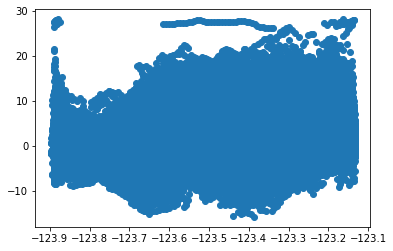

In [136]:
plt.plot(temp3.Lon, temp3.mod_vosaline - temp3.SA, 'o')

In [191]:
## Remove some bad data
#cleaned = temp3[(temp3.Lon > -123.8) | (temp3.SA > 14)]
more_clean = temp3[((temp3.SA > 0.2) | (temp3.mod_vosaline - temp3.SA < 20)) & ((temp3.Lon > -123.8) | (temp3.SA > 14))]

In [194]:
def cleanup_ferry(temp3):
    return temp3[((temp3.SA > 0.2) | (temp3.mod_vosaline - temp3.SA < 20)) & ((temp3.Lon > -123.8) | (temp3.SA > 14))]

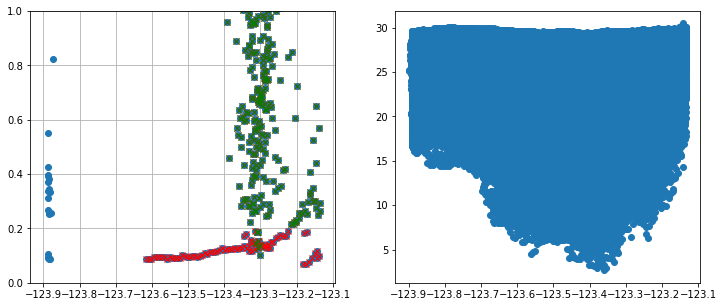

In [192]:
fig, axs = plt.subplots(1, 2, figsize= (12, 5))
axs[0].plot(temp3.Lon, temp3.SA, 'o');
axs[0].plot(cleaned.Lon, cleaned.SA, 'rx');
axs[0].plot(more_clean.Lon, more_clean.SA, 'gx')
axs[1].plot(temp3.Lon, temp3.mod_vosaline, 'o');
axs[0].set_ylim(0, 1);
axs[0].grid();

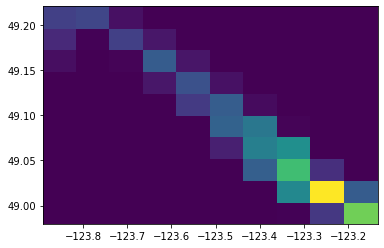

In [139]:
plt.hist2d(temp1.Lon[temp3.mod_vosaline-temp3.SA > 5], temp1.Lat[temp3.mod_vosaline-temp3.SA > 5]);

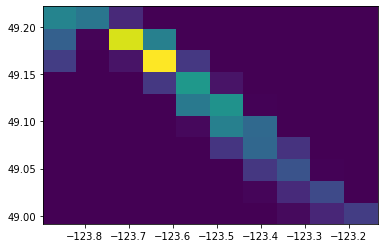

In [140]:
plt.hist2d(temp1.Lon[temp3.mod_vosaline-temp3.SA < -5], temp1.Lat[temp3.mod_vosaline-temp3.SA < -5]);

1.2894794145698605
0.010057788012282985
251727


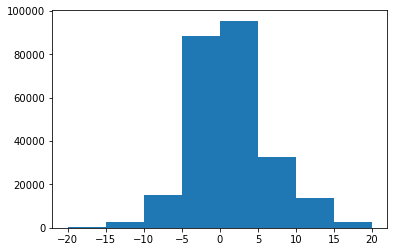

In [141]:
plt.hist(temp4.mod_vosaline - temp4.SA, bins=[-20, -15, -10, -5, 0, 5, 10, 15, 20])
print ((temp4.mod_vosaline - temp4.SA).mean())
print ((temp4.mod_vosaline - temp4.SA).std()/np.sqrt((temp4.mod_vosaline - temp4.SA).count()))
print ((temp4.mod_vosaline - temp4.SA).count())

In [ ]:
## And now bin across the Strait

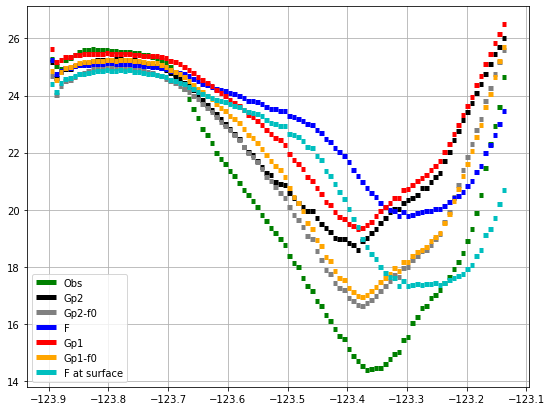

In [143]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7))
bin_means, bin_edges, binnumber = stats.binned_statistic(temp4.Lon, temp4.SA, 'mean', bins=100)
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=5,
               label='Obs');
bin_means, bin_edges, binnumber = stats.binned_statistic(temp1.Lon, temp1.mod_vosaline, 'mean', bins=100)
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='k', lw=5,
               label='Gp2');
bin_means, bin_edges, binnumber = stats.binned_statistic(tempGp2f.Lon, tempGp2f.mod_vosaline, 'mean', bins=100)
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='gray', lw=5,
               label='Gp2-f0');
bin_means, bin_edges, binnumber = stats.binned_statistic(temp2.Lon, temp2.mod_vosaline, 'mean', bins=100)
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='b', lw=5,
               label='F');
bin_means, bin_edges, binnumber = stats.binned_statistic(temp3.Lon, temp3.mod_vosaline, 'mean', bins=100)
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=5,
               label='Gp1');
bin_means, bin_edges, binnumber = stats.binned_statistic(tempGp1f.Lon, tempGp1f.mod_vosaline, 'mean', bins=100)
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='orange', lw=5,
               label='Gp1-f0');
bin_means, bin_edges, binnumber = stats.binned_statistic(temp4.Lon, temp4.mod_vosaline, 'mean', bins=100)
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='c', lw=5,
               label='F at surface');
plt.grid();
plt.legend(loc='lower left');

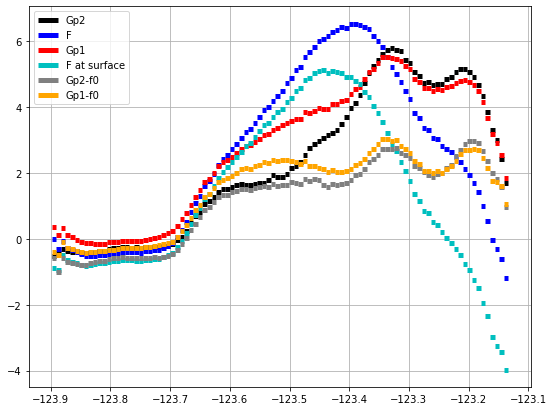

In [144]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7))
bin_means, bin_edges, binnumber = stats.binned_statistic(temp1.Lon, temp1.mod_vosaline - temp1.SA, 'mean', bins=100)
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='k', lw=5,
               label='Gp2');
bin_means, bin_edges, binnumber = stats.binned_statistic(temp2.Lon, temp2.mod_vosaline - temp2.SA, 'mean', bins=100)
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='b', lw=5,
               label='F');
bin_means, bin_edges, binnumber = stats.binned_statistic(temp3.Lon, temp3.mod_vosaline - temp3.SA, 'mean', bins=100)
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=5,
               label='Gp1');
bin_means, bin_edges, binnumber = stats.binned_statistic(temp4.Lon, temp4.mod_vosaline - temp4.SA, 'mean', bins=100)
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='c', lw=5,
               label='F at surface');
bin_means, bin_edges, binnumber = stats.binned_statistic(tempGp2f.Lon, tempGp2f.mod_vosaline - tempGp2f.SA, 'mean', bins=100)
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='gray', lw=5,
               label='Gp2-f0');
bin_means, bin_edges, binnumber = stats.binned_statistic(tempGp1f.Lon, tempGp1f.mod_vosaline - tempGp1f.SA, 'mean', bins=100)
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='orange', lw=5,
               label='Gp1-f0');
plt.legend(loc='upper left');
plt.grid();